In [3]:
from google.colab import files

# Choisissez un fichier sur votre PC
uploaded = files.upload()

Saving data_label.csv to data_label.csv


In [4]:
import shutil

# Copier le fichier depuis l'environnement Colab vers Drive
shutil.move('/content/data_label.csv', '/content/drive/MyDrive/data_label.csv')

print("✅ Fichier 'data_label.csv' déplacé dans Google Drive /MyDrive avec succès !")

✅ Fichier 'data_label.csv' déplacé dans Google Drive /MyDrive avec succès !


 Chargement et Affichage du Dataset pour l'Analyse de Sentiment

In [5]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/data_label.csv')
df

,comment_cleaned,sentiment
0,nice,positive
1,wow superb,positive
2,congratulation,positive
3,hyundai perfect,positive
4,perfect car family,positive
...,...,...
6877,lady ciarahi minnesota im man fan fromtry chan...,positive
6878,wear like set trend trust people notice stand ...,neutral
6879,yes baby pink boho chic wear lot kind bored wh...,neutral
6880,articulate fun listen favorite fashion youtuber,positive


Préparation des Données : Séparation Entraînement/Test pour l'Analyse de Sentiment

In [6]:
from sklearn.model_selection import train_test_split

# Diviser les données
X = df['comment_cleaned']           # Caractéristiques (features)
y = df['sentiment']      # Étiquettes (labels)

# Split en 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Affichage pour vérification
print(f"Taille train : {len(X_train)}, Taille test : {len(X_test)}")


Taille train : 5505, Taille test : 1377


Mapping des étiquettes sentimentales en valeurs numériques

In [7]:
# Dictionnaire de mapping des labels
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# Appliquer le mapping sur les ensembles d'entraînement et de test
y_train_mapped = y_train.map(label_map).tolist()
y_test_mapped = y_test.map(label_map).tolist()

# Affichage pour vérifier
print("Exemples de y_train :", y_train_mapped[:5])
print("Exemples de y_test  :", y_test_mapped[:5])


Exemples de y_train : [0, 0, 2, 0, 0]
Exemples de y_test  : [2, 0, 2, 2, 2]


Tokenization avec RobertaTokenizer

In [4]:
#!pip install transformers


Importer le tokenizer de RoBERTa et l’initialiser

In [8]:
from transformers import RobertaTokenizer

# Initialisation du tokenizer RoBERTa base
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenisation des textes (train et test)

In [9]:
# Tokeniser les données d'entraînement
train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

# Tokeniser les données de test
test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)


Création d’un SentimentDataset pour RoBERTa



In [10]:
import torch
from torch.utils.data import Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


Créer les datasets d'entraînement et de test

In [11]:
# Créer les datasets
train_dataset = SentimentDataset(train_encodings, y_train_mapped)
test_dataset = SentimentDataset(test_encodings, y_test_mapped)



Define RoBERTa Model for Sequence Classification

In [12]:
from transformers import RobertaForSequenceClassification

# Définir le modèle RoBERTa avec 3 étiquettes de sortie
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=3  # car on a 3 classes de sentiment
)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define compute_metrics Function for More Detailed Evaluation

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


Define Final TrainingArguments with Regularization and Early Stopping

In [11]:
!pip install -U transformers --quiet



In [12]:
import inspect
print(inspect.signature(TrainingArguments.__init__))


(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict[str, Any], str, NoneType] = <factory>, warmup_ratio: float = 0.0, 

In [15]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/models',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.05,
    logging_dir='/content/drive/MyDrive/logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_accumulation_steps=2,
    logging_steps=10,
    save_total_limit=2,
    report_to="none"
)


Early Stopping pour Prévenir le Surapprentissage

In [16]:
from transformers import EarlyStoppingCallback

# Callback d'early stopping avec une patience de 5 époques
early_stopping = EarlyStoppingCallback(early_stopping_patience=5)


Entraînement et Évaluation du Modèle avec Trainer

In [17]:
from transformers import Trainer

# Configuration du Trainer
trainer = Trainer(
    model=model,                         # Modèle RoBERTa défini précédemment
    args=training_args,                  # Arguments d'entraînement
    train_dataset=train_dataset,         # Dataset d'entraînement
    eval_dataset=test_dataset,            # Dataset d'évaluation
    compute_metrics=compute_metrics,      # Fonction métriques personnalisée
    callbacks=[early_stopping]             # Callback d'arrêt anticipé
)

In [18]:
# Lancer l'entraînement
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.518900,0.519355,0.802469,0.806036,0.802469,0.778685
2,0.476800,0.461527,0.824982,0.830305,0.824982,0.825101
3,0.338000,0.503283,0.834423,0.840979,0.834423,0.829051
4,0.197300,0.454498,0.857662,0.855666,0.857662,0.854460


TrainOutput(global_step=692, training_loss=0.47530799629328224, metrics={'train_runtime': 522.8589, 'train_samples_per_second': 42.115, 'train_steps_per_second': 1.323, 'total_flos': 1448439364592640.0, 'train_loss': 0.47530799629328224, 'epoch': 4.0})

In [19]:
# Effectuer les prédictions sur le jeu de test
predictions_output = trainer.predict(test_dataset)


In [21]:
predictions_output

PredictionOutput(predictions=array([[-2.6396916 , -1.4974029 ,  4.323383  ],
       [ 2.308923  , -1.3748881 , -0.8430551 ],
       [ 0.92937106, -1.0025309 ,  0.2153089 ],
       ...,
       [-2.1802022 , -2.026365  ,  4.4040194 ],
       [ 3.9036875 , -1.311062  , -2.4125953 ],
       [-1.0383887 , -0.41725653,  1.6561943 ]], dtype=float32), label_ids=array([2, 0, 2, ..., 2, 0, 2]), metrics={'test_loss': 0.45449841022491455, 'test_accuracy': 0.8576615831517792, 'test_precision': 0.8556664003657704, 'test_recall': 0.8576615831517792, 'test_f1': 0.8544598077700203, 'test_runtime': 8.7344, 'test_samples_per_second': 157.652, 'test_steps_per_second': 9.961})

In [22]:
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.45449841022491455, 'eval_accuracy': 0.8576615831517792, 'eval_precision': 0.8556664003657704, 'eval_recall': 0.8576615831517792, 'eval_f1': 0.8544598077700203, 'eval_runtime': 8.6717, 'eval_samples_per_second': 158.792, 'eval_steps_per_second': 10.033, 'epoch': 4.0}


In [20]:
# Extraire les probabilités et convertir en classes
pred_probs = predictions_output.predictions
pred_labels = pred_probs.argmax(axis=1)

print(f"Exemple de labels prédits : {pred_labels[:10]}")

Exemple de labels prédits : [2 0 0 2 2 2 1 0 0 2]


Afficher le rapport de classification et la matrice de confusion

Rapport de classification :
               precision    recall  f1-score   support

    negative       0.85      0.93      0.88       572
     neutral       0.78      0.62      0.69       231
    positive       0.90      0.88      0.89       574

    accuracy                           0.86      1377
   macro avg       0.84      0.81      0.82      1377
weighted avg       0.86      0.86      0.85      1377



<Figure size 800x600 with 0 Axes>

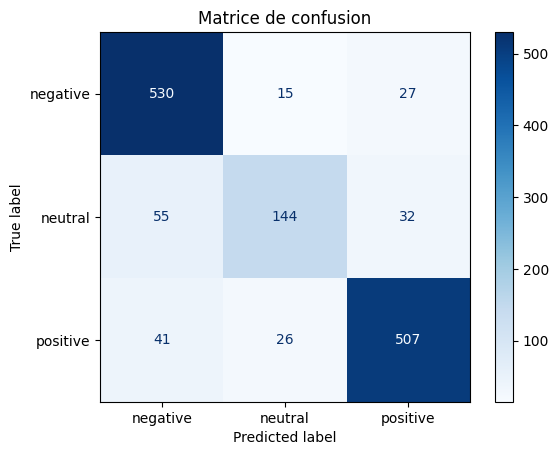

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test_mapped : labels réels (numériques)
# pred_labels : labels prédits (issus de trainer.predict)

# Rapport de classification
report = classification_report(y_test_mapped, pred_labels, target_names=['negative', 'neutral', 'positive'])
print("Rapport de classification :\n", report)

# Matrice de confusion
cm = confusion_matrix(y_test_mapped, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

# Affichage graphique de la matrice
plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


Sauvegarder le modèle entraîné

In [27]:
# Chemin où sauvegarder le modèle
model_save_path = "/content/drive/MyDrive/roberta_sentiment_model"

# Sauvegarde
trainer.save_model(model_save_path)
print(f"Modèle sauvegardé dans : {model_save_path}")


Modèle sauvegardé dans : /content/drive/MyDrive/roberta_sentiment_model


Pipeline complet pour l’analyse de sentiment avec XLNet

Chargement et affichage du dataset

In [28]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/data_label.csv')
print(df.head())


      comment_cleaned sentiment
0                nice  positive
1          wow superb  positive
2      congratulation  positive
3     hyundai perfect  positive
4  perfect car family  positive


Séparation entraînement / test

In [29]:
from sklearn.model_selection import train_test_split

X = df['comment_cleaned']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Taille train : {len(X_train)}, Taille test : {len(X_test)}")


Taille train : 5505, Taille test : 1377


Mapping des labels sentimentaux en valeurs numériques



In [30]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

y_train_mapped = y_train.map(label_map).tolist()
y_test_mapped = y_test.map(label_map).tolist()


Tokenization avec XLNetTokenizer

In [31]:
from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Création d’un dataset personnalisé

In [32]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train_mapped)
test_dataset = SentimentDataset(test_encodings, y_test_mapped)


Définition du modèle XLNet pour classification

In [33]:
from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained(
    'xlnet-base-cased',
    num_labels=3
)


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fonction pour calculer les métriques

In [34]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


Configuration des arguments d’entraînement

In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/xlnet_models',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.05,
    logging_dir='/content/drive/MyDrive/xlnet_logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_accumulation_steps=2,
    logging_steps=10,
    save_total_limit=2,
    report_to="none"
)


Early Stopping Callback

In [36]:
from transformers import EarlyStoppingCallback

early_stopping = EarlyStoppingCallback(early_stopping_patience=5)


nitialisation du Trainer



In [37]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


Entraînement du modèle

In [38]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.208200,0.561755,0.766885,0.749848,0.766885,0.725124
2,0.954600,0.433385,0.838054,0.836613,0.838054,0.835686
3,0.822900,0.461601,0.835875,0.837646,0.835875,0.830022
4,0.358000,0.467414,0.854031,0.851275,0.854031,0.849614


TrainOutput(global_step=692, training_loss=1.058469809634837, metrics={'train_runtime': 691.0158, 'train_samples_per_second': 31.866, 'train_steps_per_second': 1.001, 'total_flos': 1568278943769600.0, 'train_loss': 1.058469809634837, 'epoch': 4.0})

Prédictions sur le jeu de test

In [39]:
predictions_output = trainer.predict(test_dataset)

pred_probs = predictions_output.predictions
pred_labels = pred_probs.argmax(axis=1)

print(f"Exemple de labels prédits : {pred_labels[:10]}")


Exemple de labels prédits : [2 0 2 2 0 2 1 0 0 2]


Rapport de classification et matrice de confusion

Rapport de classification :
               precision    recall  f1-score   support

    negative       0.83      0.91      0.87       572
     neutral       0.74      0.63      0.68       231
    positive       0.88      0.85      0.87       574

    accuracy                           0.84      1377
   macro avg       0.82      0.80      0.80      1377
weighted avg       0.84      0.84      0.84      1377



<Figure size 800x600 with 0 Axes>

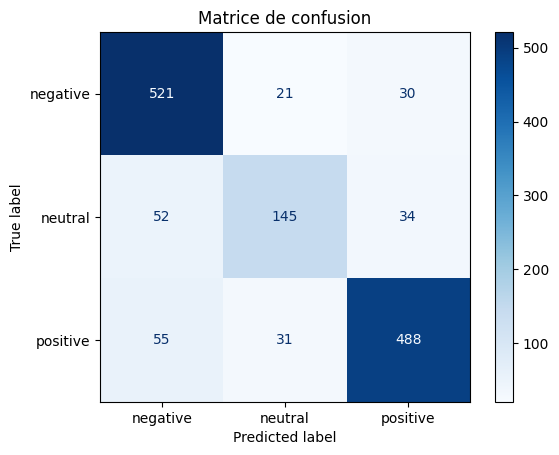

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

report = classification_report(y_test_mapped, pred_labels, target_names=['negative', 'neutral', 'positive'])
print("Rapport de classification :\n", report)

cm = confusion_matrix(y_test_mapped, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


Courbes Loss & métriques par époque

Sauvegarde du modèle

In [42]:
model_save_path = "/content/drive/MyDrive/xlnet_sentiment_model"
trainer.save_model(model_save_path)
print(f"Modèle sauvegardé dans : {model_save_path}")


Modèle sauvegardé dans : /content/drive/MyDrive/xlnet_sentiment_model


In [43]:
import json

# Chemin vers ton notebook local sur Colab (généralement '/content/ton_fichier.ipynb')
notebook_path = '/content/drive/MyDrive/Colab Notebooks/sentimentanalysisnlp.ipynb'  # Change le chemin si besoin

# Charger le notebook
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = json.load(f)

# Supprimer la clé 'widgets' dans metadata s'il existe
if 'widgets' in notebook.get('metadata', {}):
    del notebook['metadata']['widgets']

# Sauvegarder le notebook nettoyé
with open(notebook_path, 'w', encoding='utf-8') as f:
    json.dump(notebook, f, indent=2)

print("Metadata 'widgets' supprimé, notebook prêt pour GitHub.")


Metadata 'widgets' supprimé, notebook prêt pour GitHub.
